<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Projeto 3 - Ciência dos Dados</p>

Alunos:
<ul style="font-family:monospace">
    <li>Cicero Tiago Carneiro Valentim</li>
    <li>Luiz Felipe Lazzaron</li>
    <li>Marcos Vinícius da Silva</li>
    <li>Thalia Loiola Silva</li>
</ul>

In [107]:
from imports import *
%matplotlib inline

In [108]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

In [109]:
airbnb.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [110]:
# limpar colunas desnecessárias:
airbnb = airbnb.drop(columns=["id","name","host_name","minimum_nights","last_review", 'reviews_per_month', 'calculated_host_listings_count', 'host_id'])

In [111]:
# analisar a coluna "room_type", pois ela parece ser relevante para a análise
airbnb["room_type"].value_counts() # Essa coluna mostrou bastante potencial como variável qualitativa

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [112]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,355


### Separação em teste e treinamento

In [113]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(airbnb, airbnb["room_type"]):
    strat_train_set = airbnb.loc[train_index]
    strat_test_set = airbnb.loc[test_index]

In [114]:
strat_train_set.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
12776,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,130,67,252
38717,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,312,0,38
35008,Manhattan,West Village,40.73202,-74.00348,Private room,150,2,56
266,Brooklyn,Williamsburg,40.70690,-73.95467,Private room,60,14,362
38787,Brooklyn,Bedford-Stuyvesant,40.69054,-73.92801,Entire home/apt,75,4,10


In [115]:
airbnb = strat_train_set.drop("price", axis=1)
airbnb_labels = strat_train_set["price"].copy()

In [116]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,number_of_reviews,availability_365
12776,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,67,252
38717,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,0,38


In [117]:
airbnb.shape, airbnb_labels.shape

((39116, 7), (39116,))

In [118]:
num_attribs = list(airbnb.drop(columns=["neighbourhood_group","neighbourhood","room_type"]).columns)
cat_attribs = ["neighbourhood_group","neighbourhood","room_type"]

num_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(num_attribs) ),
    ('imputer', SimpleImputer(strategy="median")),
    ( 'std_scaler', StandardScaler() )
])
cat_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(cat_attribs) ),
    ( 'label_encoder', LabelEncoder())
])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
])

In [119]:
airbnb_prepared = full_pipeline.fit_transform(airbnb)

In [120]:
some_data = airbnb.iloc[:8]

In [121]:
some_labels = airbnb_labels.iloc[:8]

In [122]:
some_data_prepared = full_pipeline.transform(some_data)

<hr><p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace">Regressão Logística</p><hr>

 A regressão logística é uma ferramenta da estatística usada, em geral, para modelar um resultado binomial (1 ou 0), determinando sucesso ou fracasso de determinado acontecimento. 

In [123]:
time_init = time()

log_reg = LogisticRegression()
log_reg.fit(airbnb_prepared, airbnb_labels)

print("\nTempo gasto: {:.2f} segundos".format(time() - time_init))


Tempo gasto: 64.91 segundos


In [124]:
print("Predictions:\t", list(log_reg.predict(some_data_prepared)))
print("Labels:\t\t", list(some_labels))

Predictions:	 [150, 200, 100, 60, 150, 100, 150, 125]
Labels:		 [130, 312, 150, 60, 75, 180, 399, 119]


In [125]:
time_init = time()

log_rmse_scores = cross_val_score(log_reg, airbnb_prepared, airbnb_labels,
                             scoring="neg_mean_squared_error", cv=10)

print("\nTempo gasto: {:.2f} segundos".format(time() - time_init))


Tempo gasto: 532.26 segundos


In [126]:
display_scores(log_rmse_scores)

Scores: [-232229.4753603  -114523.14937759  -62779.69650873  -23538.35428282
  -22990.16850474  -15720.72394073  -15380.56144958  -13089.30490066
  -10702.9435527   -11038.08554413]
Mean: -52199.246342198465
Standard deviation: 67611.97017849261


In [127]:
airbnb_predictions = log_reg.predict(airbnb_prepared)

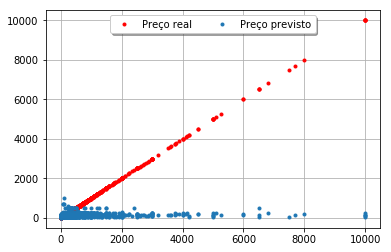

In [128]:
ax = plt.subplot(111)
plt.plot(airbnb_labels, airbnb_labels, 'r.', label='Preço real')
plt.plot(airbnb_labels, airbnb_predictions, '.', label='Preço previsto')
plt.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.show()

Note que o gráfico acima está baseado em valores que foram apresentados pela coluna "Price" do dataset que está sendo analisado versus o valor que foi previsto usando a ferramenta de Regressão Logística. O eixo y, para os valores em azul, está sendo representado pelos valores previstos.

Esse modelo, no entanto, não é o que melhor cumpre o esperado, uma vez que os valores são consideravelmente diferentes dos reais, como é mostrado no gráfico.